In [1]:
from langdetect import detect
import re
from Scripts import loading as dl, profiling as pf, cleaning as cl
import matplotlib.pyplot as plt

In [2]:
# Input
db_path = '../Data/moviewreviews.db'
db_name = 'moviereviews'
df = dl.load_from_db(db_path, db_name)

In [3]:
df.head()

,NODE,URL,REVIEWBODY,RATING,REVIEWRATING,BESTRATING,WORSTRATING
0,_:nodea456ab92b2669279485e1ddc64944bf0,https://in.bookmyshow.com/amritsar/movies/hous...,"""Housefull 4 is about the mistaken identities,...",_:nodee7b066aef1465ef6796152d5b23eefd,2.5,"""Null""@en","""2""@en"
1,_:nodee7b066aef1465ef6796152d5b23eefd,https://in.bookmyshow.com/amritsar/movies/hous...,None,None,"""Null""@en","""Null""@en","""2""@en"
2,_:node3b52118bf545246233aa662aad8a194,https://in.bookmyshow.com/amritsar/movies/hous...,"""Overall, Housefull 4 ends up as a complete ma...",_:nodef82d8af1d090997015dbe94ab45ad,2.5,"""Null""@en","""2""@en"
3,_:nodef82d8af1d090997015dbe94ab45ad,https://in.bookmyshow.com/amritsar/movies/hous...,None,None,"""Null""@en","""Null""@en","""2""@en"
4,_:nodeecc0f025103514ba011df1542adef7b,https://in.bookmyshow.com/amritsar/movies/hous...,"""HOUSEFULL 4 is a major disappointment and suf...",_:node5e5e1ef8427cb3f95ead0badefcd4c8,2,"""Null""@en","""2""@en"


In [24]:
total = len(df)
df.describe()

,REVIEWRATING_new,BESTRATING_new,WORSTRATING_new,REVIEWRATING_adj
count,76451.000000,76451.000000,76451.000000,76451.000000
mean,13.521053,27.368995,0.478843,3.242168
std,19.156030,37.572783,0.499555,1.164397
min,0.000000,4.000000,0.000000,1.000000
25%,3.000000,5.000000,0.000000,3.000000
50%,5.000000,10.000000,0.000000,3.000000
75%,10.000000,10.000000,1.000000,4.000000
max,99.000000,99.000000,1.000000,5.000000


In [25]:
# DATA COMPLETENESS
# Del incomplete entries based on missing values
print('Missing review data as percentage: {:.2%} '.format(len(df[df.REVIEWBODY.isnull()])/len(df)))
print('Missing rating information as percentage: {:.2%}'.format(len(df[df.REVIEWBODY.isnull()&df.RATING.isnull()&df.REVIEWRATING.isnull()&df.BESTRATING.isnull()&df.WORSTRATING.isnull()])/total))
df = df[df.REVIEWBODY.notnull()&df.RATING.notnull()&df.REVIEWRATING.notnull()&df.BESTRATING.notnull()&df.WORSTRATING.notnull()]
print("After removing missing text and ratings: ", len(df))

Missing review data as percentage: 0.00% 
Missing rating information as percentage: 0.00%
After removing missing text and ratings:  76451


In [6]:
# Del incomplete entries based on implictly missing values
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)
def checkmisrat(row):
    result = hasNumbers(row['REVIEWRATING']) and hasNumbers(row['BESTRATING']) and hasNumbers(row['WORSTRATING'])
    return result
df['mis_rat'] = df.apply(checkmisrat, axis=1)
print('Implicitly missing rating data as percentage: {:.2%} '.format((len(df[df['mis_rat']==False]))/total))
df = df[df['mis_rat']==True]
print("After removing implictly missing rating information: ", len(df))

Implicitly missing rating data as percentage: 12.91% 
After removing implictly missing rating information:  96658


In [7]:
# Generally del missing values (should not change much by now)
df.dropna()
len(df)

96658

In [8]:
# DUPLICATION DELETION

df_dup = df[df.duplicated(subset=['REVIEWBODY','REVIEWRATING'], keep='last')]
df_dup2 = df[df.duplicated(subset=['REVIEWBODY'], keep='last')]
print("Duplicate text and label from reviews without missing information: {:.2%}".format(len(df_dup)/ len(df)))
print("Duplicate text: {:.2%}".format(len(df_dup2)/ len(df)))

df= df.drop_duplicates(subset=['REVIEWBODY','REVIEWRATING'], keep='last')
df = df.drop_duplicates(subset=['REVIEWBODY'], keep='last')
print("After removing duplicate entries and texts: ", len(df))

Duplicate text and label from reviews without missing information: 20.30%
Duplicate text: 20.34%
After removing duplicate entries and texts:  76997


In [9]:
# NON-ENGLISH TEXT DELETION
def detectLang(row):
    try:
        return detect(row['REVIEWBODY'])
    except:
        print("exception:", row['REVIEWBODY'])
    else:
        print("sad:", row['REVIEWBODY'])
df['LANGUAGE'] = df.apply(detectLang, axis=1)
df['LANGUAGE'].value_counts()

exception: 
exception: ....
exception:  


en    76451
fr       79
no       55
pt       44
af       37
nl       36
it       35
ca       31
ro       29
da       27
cy       25
tl       25
es       18
de       17
et       16
so       15
sv       13
id       12
fi        7
sq        4
hr        4
hu        3
sl        3
sw        3
tr        2
lt        1
pl        1
lv        1
Name: LANGUAGE, dtype: int64

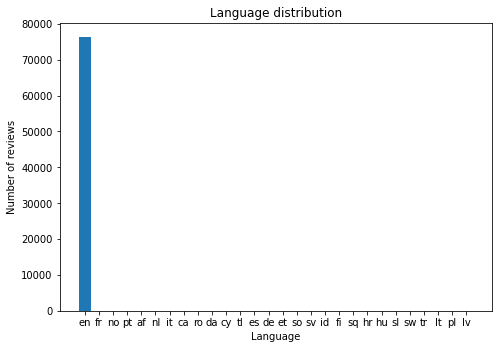

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = df['LANGUAGE'].value_counts().index
y = df['LANGUAGE'].value_counts()
ax.bar(x,y)
plt.xlabel('Language')
plt.ylabel('Number of reviews')
plt.title(f'Language distribution')
plt.rcParams['figure.facecolor'] = 'white'
plt.show()
fig.savefig("../Figures/schema_movie_lang_dist.png")

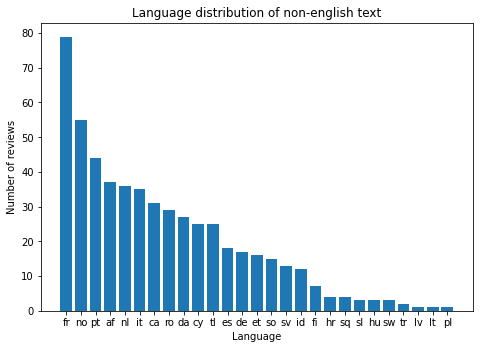

In [14]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = df[df['LANGUAGE']!='en']['LANGUAGE'].value_counts().index
y = df[df['LANGUAGE']!='en']['LANGUAGE'].value_counts()
ax.bar(x,y)
plt.xlabel('Language')
plt.ylabel('Number of reviews')
plt.title(f'Language distribution of non-english text')
plt.rcParams['figure.facecolor'] = 'white'
plt.show()

In [15]:
df = df[df['LANGUAGE'] == "en"]
print("After removing non-english text:", len(df))

After removing non-english text: 76451


In [16]:
# ADJUSTING THE RATING VALUES
df['REVIEWRATING'].value_counts().index.tolist()
# df['BESTRATING'].value_counts().index.tolist()
# df['WORSTRATING'].value_counts().index.tolist()

def chForm(value):
    value = re.sub(r'[a-zA-Z]|@|%| |"|-|\\', '', value)
    # return value
    if value != "":
        value = float(value)
    else:
        value = float(0)
    return round(value)
df['REVIEWRATING_new'] = df.apply(lambda row: chForm(row['REVIEWRATING']), axis=1)
df['BESTRATING_new']= df.apply(lambda row: chForm(row['BESTRATING']), axis=1)
df['WORSTRATING_new']= df.apply(lambda row: chForm(row['WORSTRATING']), axis=1)

In [17]:
df['REVIEWRATING_new'].value_counts().index.tolist()
# df['BESTRATING_new'].value_counts().index.tolist()
# df['WORSTRATING_new'].value_counts().index.tolist()

[4,
 3,
 2,
 1,
 10,
 5,
 7,
 8,
 6,
 39,
 9,
 59,
 49,
 29,
 19,
 69,
 79,
 0,
 89,
 99,
 44,
 54,
 20,
 64,
 33,
 34,
 70,
 45,
 55,
 50,
 58,
 42,
 24,
 30,
 74,
 40]

In [18]:
df['REVIEWRATING_new'].value_counts()


4     11112
3      9911
2      9069
1      4992
10     4948
5      4417
7      4186
8      4179
6      4120
39     3636
9      2997
59     2983
49     2649
29     1911
19     1894
69     1633
79      996
0       565
89      143
99       42
44       34
54       13
20        3
64        3
33        2
34        2
70        2
45        1
55        1
50        1
58        1
42        1
24        1
30        1
74        1
40        1
Name: REVIEWRATING_new, dtype: int64

In [19]:
def adjust_rating(n, range1, range2):
    try:
        if n > range1[1]:
            return range2[1]
        delta1 = range1[1] - range1[0]
        delta2 = range2[1] - range2[0]
        result =  (round(delta2 * (n - range1[0]) / delta1) + range2[0])
        if result == 0:
            result = 1
        return result
    except ZeroDivisionError:
        if range1 == [5,5]:
            return  5

df['REVIEWRATING_adj'] = df.apply(lambda row: adjust_rating(row['REVIEWRATING_new'], [row['WORSTRATING_new'],row['BESTRATING_new']], [1.0,5.0]), axis=1)

In [20]:
print(df['REVIEWRATING_adj'].value_counts(normalize=True))
print(df['REVIEWRATING_adj'].value_counts())

3.0    0.349767
4.0    0.243869
5.0    0.164851
2.0    0.151627
1.0    0.089888
Name: REVIEWRATING_adj, dtype: float64
3.0    26740
4.0    18644
5.0    12603
2.0    11592
1.0     6872
Name: REVIEWRATING_adj, dtype: int64


In [21]:
df.head()

,NODE,URL,REVIEWBODY,RATING,REVIEWRATING,BESTRATING,WORSTRATING,mis_rat,LANGUAGE,REVIEWRATING_new,BESTRATING_new,WORSTRATING_new,REVIEWRATING_adj
106197,_:node7788d74dd3601fb097d98e3c7d47d5a,https://thereviewmonk.com/movie/chittagong/,""" Shot ever so beautifully, Chittagong is a te...",_:nodeaca8f1a9454cb62be76f8e3bf353c69,"""6""@en-US","""10""@en-US","""0""@en-US",True,en,6,10,0,3.0
106199,_:node4d3b78dd51f3c8821591f0407881d6e,https://thereviewmonk.com/movie/chittagong/,""" This is a film that needs watching, because ...",_:nodef43da5f4ce67454a20a240eb8ed522a,"""7""@en-US","""10""@en-US","""0""@en-US",True,en,7,10,0,4.0
106201,_:nodea5179c3516155f22dfbd0e71a4691,https://thereviewmonk.com/movie/chittagong/,""" And while Chittagong falls well short of bei...",_:nodee82f2fc743cae7c3852f032e5a477c2,"""6""@en-US","""10""@en-US","""0""@en-US",True,en,6,10,0,3.0
106203,_:node7e1a7e8c2a31d8e71bf6e3fe579d1778,https://thereviewmonk.com/movie/chittagong/,""" An absolute must watch. ""@en-US",_:nodebd3ba152a61fe90c66bbd6b1bf6ccc5,"""8""@en-US","""10""@en-US","""0""@en-US",True,en,8,10,0,4.0
106205,_:node49f7761f3f49cfd93937456697796a0,https://thereviewmonk.com/movie/chittagong/,""" What makes Chittagong particularly special i...",_:node4de79f1f47fa56d5df52ceaafb81ef,"""8""@en-US","""10""@en-US","""0""@en-US",True,en,8,10,0,4.0


In [22]:
df.describe()

,REVIEWRATING_new,BESTRATING_new,WORSTRATING_new,REVIEWRATING_adj
count,76451.000000,76451.000000,76451.000000,76451.000000
mean,13.521053,27.368995,0.478843,3.242168
std,19.156030,37.572783,0.499555,1.164397
min,0.000000,4.000000,0.000000,1.000000
25%,3.000000,5.000000,0.000000,3.000000
50%,5.000000,10.000000,0.000000,3.000000
75%,10.000000,10.000000,1.000000,4.000000
max,99.000000,99.000000,1.000000,5.000000


In [23]:
df.to_csv('../Data/movie_reviews.csv')

In [ ]:
# finding out where the reviews come from (domain specific)
# def getNetloc(row):
#     try:
#         return urlparse(row['URL']).netloc
#     except:
#         print("expection: ", row['URL'])
#     else:
#         print("sad", row['URL'])
#
# df['netloc'] = df.apply(getNetloc, axis = 1)
# df.head()
# df['netloc'].value_counts().index.to_list()
# phone_lst = ['smartphone', 'phone',
#              'phone case', 'phone cable', 'phone charger', 'phone mount',
#              'cell phone', 'mobile phone']
#
#
# # df_phone = df_en[df_en['REVIEWBODY'].isin(phone_lst)]
# # print(df_phone.head())
# # LANGUAGE'] == "en"]
# df_en.head()